In [24]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [121]:
paths = ["SUMO_vis/SUMO_run/day1","SUMO_vis/SUMO_run/day2","SUMO_vis/SUMO_run/day3"]

ds = pd.DataFrame()

for path in paths:
    for file_name in os.listdir(path):
        try:
            temp = pd.read_csv(path + "//" + file_name, index_col='dateandtime',parse_dates=True)
            ds = ds.append(temp)
        except:
            ...

    

C:\Users\Nourhan.DESKTOP-MSMUPKR\AppData\Local\Temp\ipykernel_24720\997982968.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(temp)
C:\Users\Nourhan.DESKTOP-MSMUPKR\AppData\Local\Temp\ipykernel_24720\997982968.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(temp)
C:\Users\Nourhan.DESKTOP-MSMUPKR\AppData\Local\Temp\ipykernel_24720\997982968.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(temp)
C:\Users\Nourhan.DESKTOP-MSMUPKR\AppData\Local\Temp\ipykernel_24720\997982968.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(temp)
C:\Users\Nourhan.DESKTOP-MSMUPKR\AppData

In [122]:
temp = pd.pivot_table(ds,index = 'dateandtime', values ='spdK/m' , columns ='edge')

temp = temp.groupby([
            pd.Grouper(level='dateandtime'
                       , freq = '2T'  #one reading every 10 mins
                      )]
          ).mean()


In [123]:
limitPer = len(temp) *0.20
temp = temp.dropna(thresh=limitPer, axis=1)
temp.count()

edge
-178543139#2                   631
-182371955#0                   299
-182371966#0                   384
-182371966#4                   313
-182371966#5                   338
                              ... 
958778139#0-AddedOnRampEdge    659
958778139#1                    327
971350102#1                    771
:8771565273_2                  294
:8771565283_0                  671
Length: 355, dtype: int64

In [129]:
df = temp.fillna(temp.max())

In [130]:
df = df.loc[:, (temp != 0).any(axis=0)]


In [131]:
#Smooth curve
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, 
                           mode='full'
                          )
    return y_smooth

In [132]:
smoothed_df = []
for cntrDf in range(0, df.shape[-1]):
    smoothed_df.append(smooth(df.values[:,cntrDf],30))

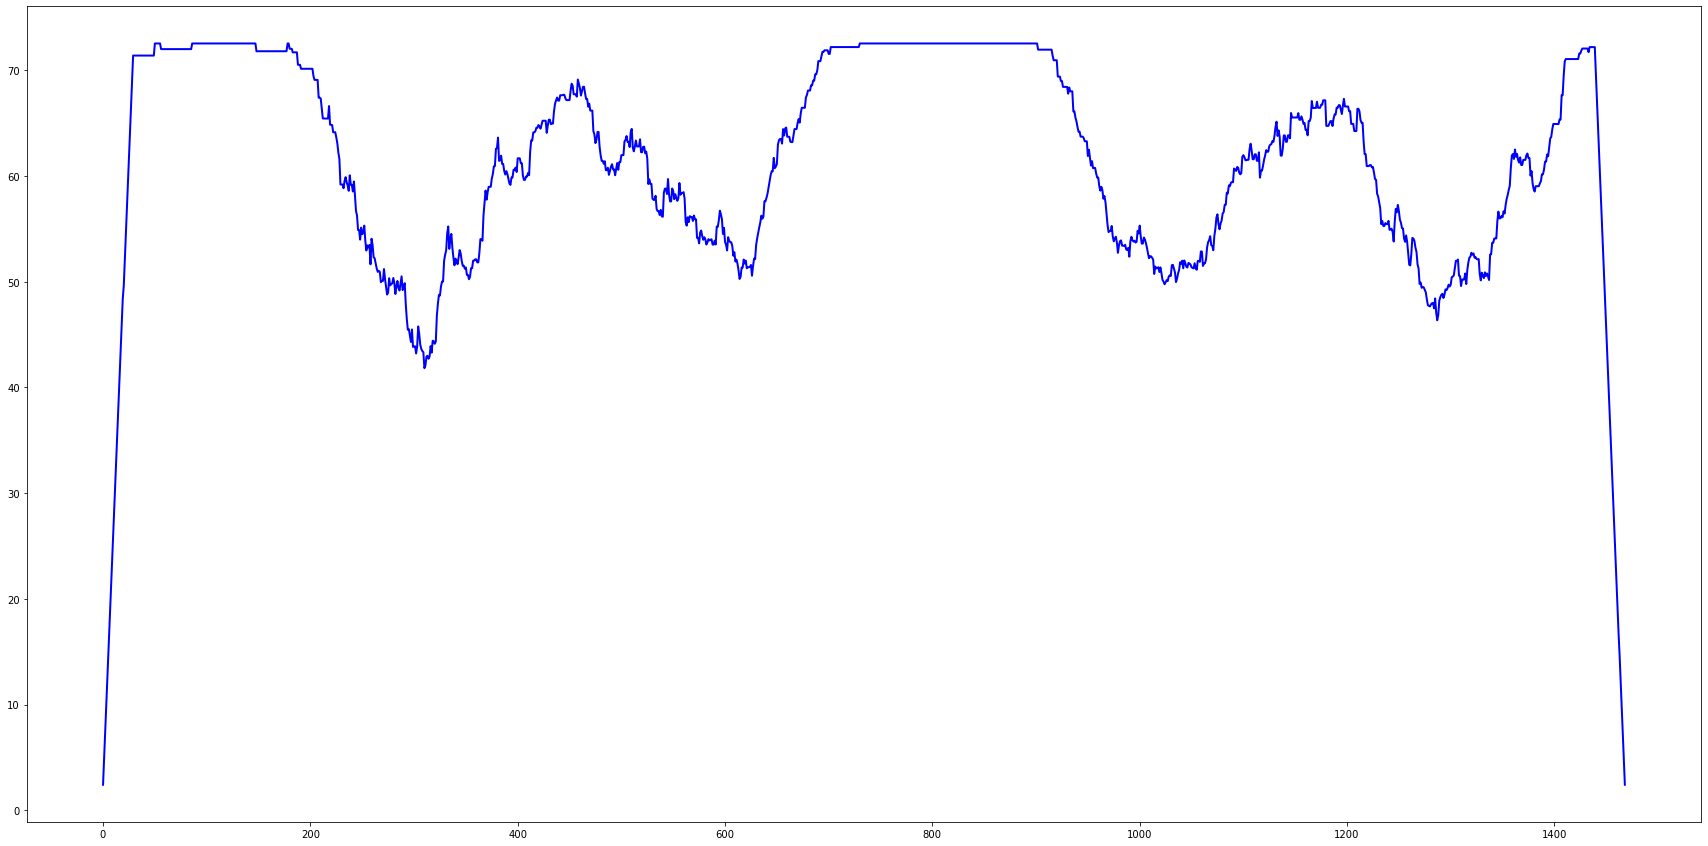

In [134]:
plt.rcParams["figure.figsize"] = (30,15)
# plt.plot(smooth(df.values[:,0],40), 'r-', lw=2)
plt.plot(smoothed_df[0], 'b-', lw=2)



In [105]:
def train_test_split(dataset, ratio):
    scaler = MinMaxScaler()

    train_size = int(len(dataset) * ratio)
    test_size = len(dataset) - train_size

    train  = dataset[0:train_size]
    test   = dataset[train_size:]
    return train,test

In [106]:
def model_train_predict(train):
    history = [x for x in train]
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    return model_fit

In [107]:
models = []
for edge in smoothed_df:
    train,test = train_test_split(edge,0.7)
    models.append(model_train_predict(train))

In [136]:
def get_predictions(edge, step):
    col = df.columns.get_loc(edge)
    forecast = models[col].forecast(steps=step)
    return forecast

In [137]:
get_predictions("-182371955#0",10)

array([46.78928131, 47.16854517, 47.66031466, 47.92589831, 48.11260015,
       48.25851822, 48.39945234, 48.50883353, 48.59236217, 48.65598533])

In [163]:
def graph_predictions(dataset,ratio):
    train,test = train_test_split(dataset,ratio)
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()


        output = model_fit.forecast()

        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        
    return predictions
    plt.plot(test)
    # plt.plot(train)
    plt.plot(predictions, color='red')
    plt.show()


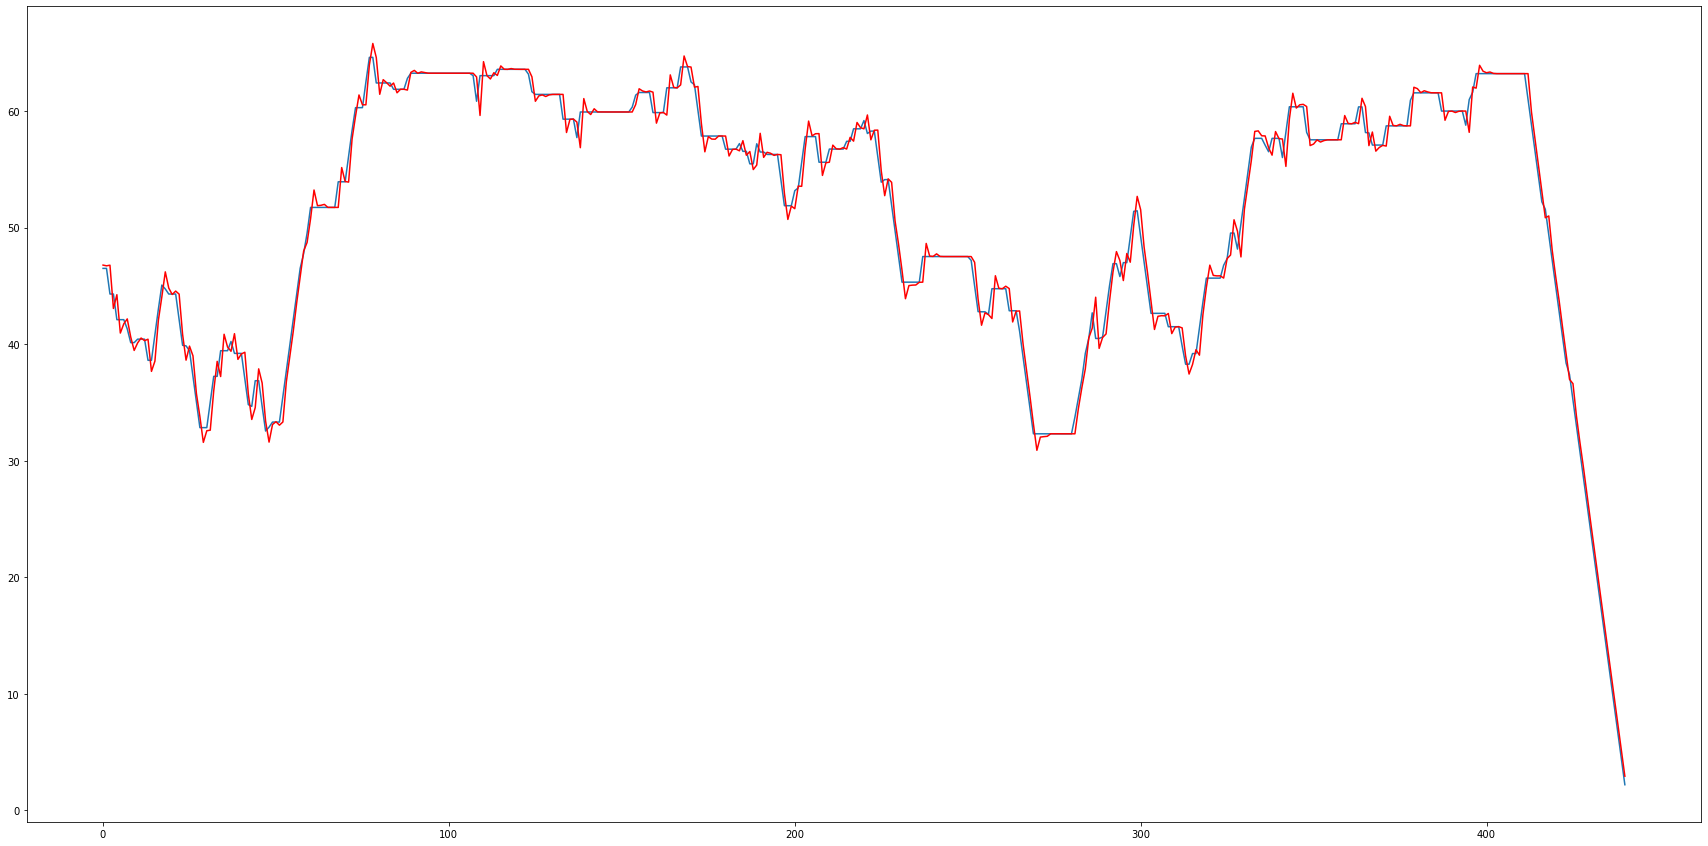

In [154]:
graph_predictions(smoothed_df[1],0.7)

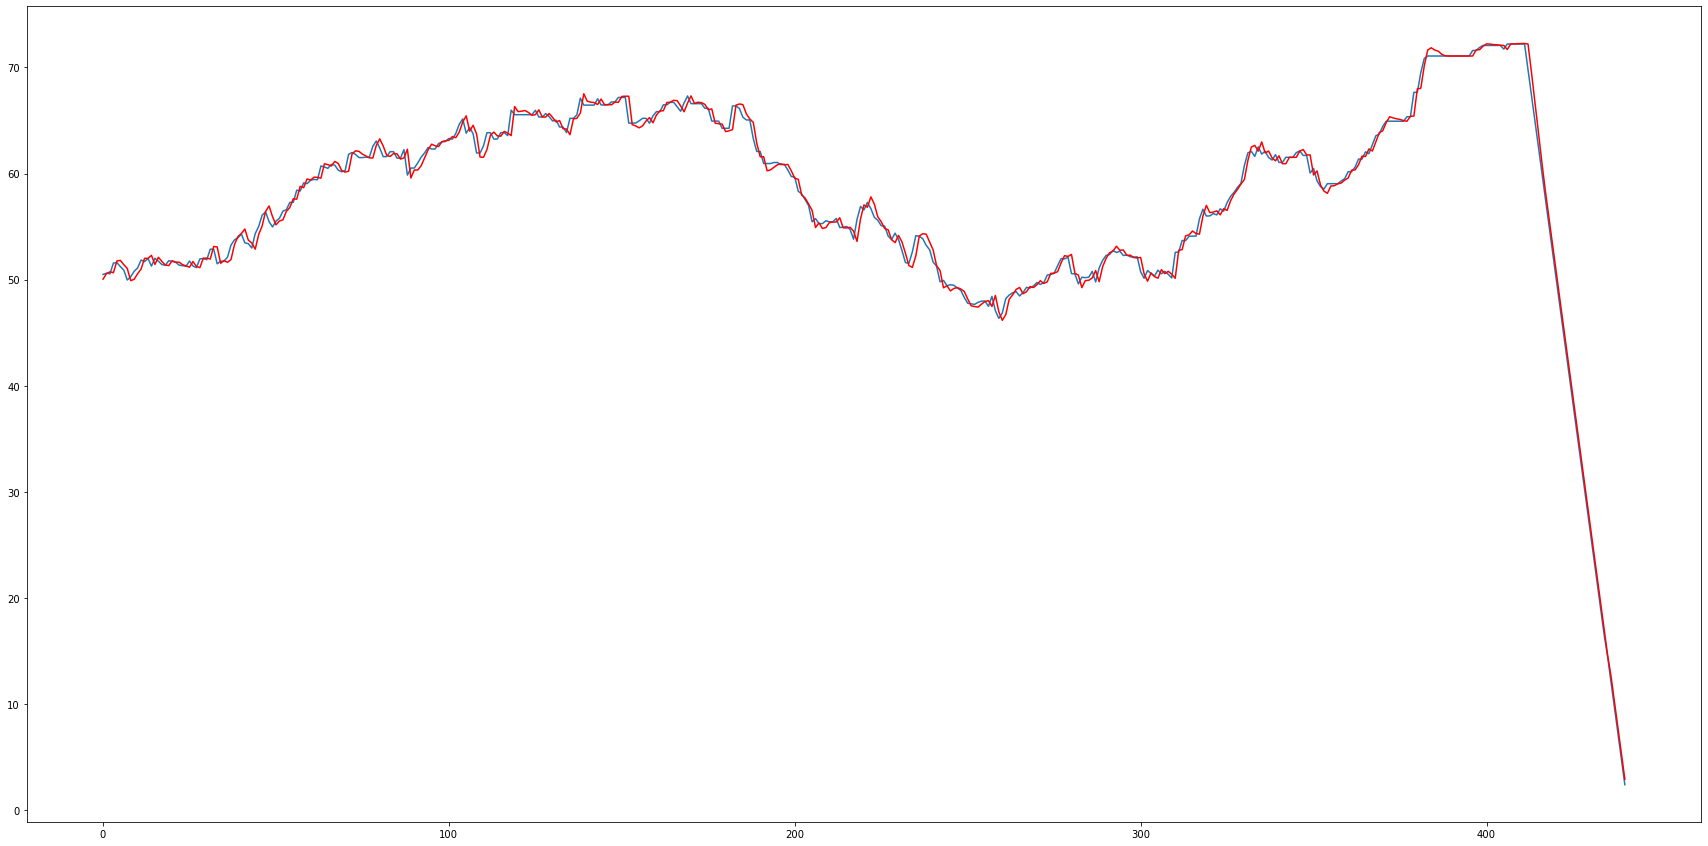

In [151]:
# evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
# plt.plot(train)
plt.plot(predictions, color='red')
plt.show()